# Are Rosetta's range rate oscillations also explained by tracking signal lag?

Range rate residual oscillations similar to those of NEAR's post-encounter Doppler were reported for Rosetta's 2005 Earth flyby, which also had an anomalous $\Delta v$ ([Refs](../README.md#references) [2]).

They are similarly reproduced below by simulation of light-time lags in the tracking signal. They incidentally vanish if the initial state for the orbital elements is taken 3 or more days before perigee, as the initial lag is then too small to inflict a significant change at and through the perigee.

In [1]:
from astropy import units as u
from astropy import constants as const
from astropy.time import Time

from poliastro.util import norm
from poliastro.frames import Planes
from poliastro.ephem import Ephem
from poliastro.bodies import Earth

from poliastro.twobody.orbit import Orbit
from poliastro.twobody.sampling import EpochsArray

from astropy.coordinates import solar_system_ephemeris

import numpy as np
import sys
sys.path.append('../')

from sim.stations import dss25, esNewNorcia
from sim.tracking import Tracking
from sim.util import describe_orbit, describe_state, describe_trajectory, compare_orbits

solar_system_ephemeris.set("de440")
rosetta_start = Tracking.ROSETTA05_PERIGEE.value - 1*u.day
rosetta_end = Tracking.ROSETTA05_PERIGEE.value + 5*u.day

In [2]:
sampling_interval = 600
sample_offsets = np.arange(0, (rosetta_end-rosetta_start)/(1*u.s), sampling_interval)
flyby_epochs = rosetta_start + (sample_offsets << u.s)
print("Start and end epochs:", flyby_epochs[0], flyby_epochs[-1], "[", flyby_epochs.size, "]")

Start and end epochs: 2005-03-03 22:09:14.000 2005-03-09 21:59:14.000 [ 864 ]


In [3]:
rosetta_goldstone_ephem = Ephem.from_horizons("Rosetta", rosetta_start, attractor=Earth, plane=Planes.EARTH_EQUATOR)
rosetta_goldstone_start_rv = rosetta_goldstone_ephem.rv(rosetta_start)
describe_state(rosetta_goldstone_start_rv, dss25, rosetta_start)


:AT: 2005-03-03 22:09:14.000
Geocentric distance: 393479.17840319034 km speed: 4.115825215630486 km / s
From Goldstone-25 : range  397656.50826994446 km , range rate  -4.313096480246172 km / s


In [4]:
rosetta_goldstone_orbit = Orbit.from_vectors(Earth, rosetta_goldstone_start_rv[0], rosetta_goldstone_start_rv[1], rosetta_start)
describe_orbit(rosetta_goldstone_orbit)


::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 144.92004171736357 deg
Eccentricity: 1.3096704074365981
Semilatus rectum: 19115.855747713194 km
Semimajor axix: -26726.619395700145 km
Periapse radius: 8276.44311766935 km , altitude: 1898.3065176693508 km


In [5]:
rosetta_extended_ephem = rosetta_goldstone_orbit.to_ephem(EpochsArray(flyby_epochs))
describe_trajectory(rosetta_extended_ephem, dss25)


::TRAJECTORY::
Start and end ranges: 395064.01977115416 km 1768247.9818912619 km
Start and end radial speeds: -4.313096480246281 km / s 4.140368867356299 km / s
Closest: 2656.903558538504 km speed 10.542396209892972 km / s  at  2005-03-04 22:09:14.000
Deflection: 99.45270258924651 deg


In [6]:
sim_meas = []

for e in flyby_epochs:
    rv = rosetta_extended_ephem.rv(e)
    ref_r, ref_rr, ref_ra = esNewNorcia.range_rate_accel(rv, e)
    sim_meas.append([ref_rr - ref_ra*ref_r/const.c])

#print(sim_meas)

In [8]:
from sim.fitorbit import OrbitFitter
fitter = OrbitFitter(rosetta_goldstone_orbit, [esNewNorcia], var=0.001, debug=True)

Range constraints:
a: -26699892.776304446 -26753346.01509584
ecc: 1.3083607370291614 1.3109800778440346
inc: 2.5268025482154366 2.5318612119756274


In [9]:
from datetime import datetime 
start_time = datetime.now()
#print(start_time)

In [10]:
fitter.fit_doppler_data(flyby_epochs, sim_meas)
time_elapsed = datetime.now() - start_time
print(fitter.report())
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

{'a': -26726619.395700146, 'ecc': 1.3096704074365981, 'inc': 2.529331880095532, 'nu': -2.383947563522261, 'raan': 2.9692968197488643, 'argp': 2.498866288180231}
{'a': -26726619.395700146, 'ecc': 1.3096704074365981, 'inc': 2.529331880095532, 'nu': -2.383947563522261, 'raan': 2.9692968197488643, 'argp': 2.498866288180231}
{'a': -26726619.395700146, 'ecc': 1.3096704074365981, 'inc': 2.529331880095532, 'nu': -2.383947563522261, 'raan': 2.9692968197488643, 'argp': 2.498866288180231}
{'a': -26726619.395700146, 'ecc': 1.3096704074365981, 'inc': 2.529331880095532, 'nu': -2.383947563522261, 'raan': 2.9692968197488643, 'argp': 2.498866288180231}
{'a': -26726619.395700146, 'ecc': 1.3096704074365981, 'inc': 2.529331880095532, 'nu': -2.383947563522261, 'raan': 2.9692968197488643, 'argp': 2.498866288180231}
{'a': -26726619.395700146, 'ecc': 1.3096704074365981, 'inc': 2.529331880133222, 'nu': -2.383947563522261, 'raan': 2.9692968197488643, 'argp': 2.498866288180231}
{'a': -26726619.395700146, 'ecc': 

In [11]:
describe_orbit(fitter.orbit)
describe_trajectory(fitter.ephem, dss25)


::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 144.92081959289888 deg
Eccentricity: 1.3096704074365981
Semilatus rectum: 19115855.747713197 m
Semimajor axix: -26726619.39570015 m
Periapse radius: 8276443.117669351 m , altitude: 1898306.5176693518 m

::TRAJECTORY::
Start and end ranges: 395063.82551078196 km 1768248.213453516 km
Start and end radial speeds: -4.313102973031956 km / s 4.140370593099914 km / s
Closest: 2656.837303480352 km speed 10.542408458894993 km / s  at  2005-03-04 22:09:14.000
Deflection: 99.45270246790227 deg


In [12]:
print(fitter.result.residual)

[-2.11807057e-03 -2.46531940e-03 -2.81442940e-03 -3.16476534e-03
 -3.51569461e-03 -3.86658859e-03 -4.21682396e-03 -4.56578408e-03
 -4.91286018e-03 -5.25745261e-03 -5.59897201e-03 -5.93684041e-03
 -6.27049232e-03 -6.59937571e-03 -6.92295300e-03 -7.24070192e-03
 -7.55211637e-03 -7.85670724e-03 -8.15400307e-03 -8.44355080e-03
 -8.72491635e-03 -8.99768518e-03 -9.26146283e-03 -9.51587537e-03
 -9.76056979e-03 -9.99521440e-03 -1.02194991e-02 -1.04331357e-02
 -1.06358581e-02 -1.08274224e-02 -1.10076073e-02 -1.11762139e-02
 -1.13330659e-02 -1.14780096e-02 -1.16109141e-02 -1.17316709e-02
 -1.18401942e-02 -1.19364205e-02 -1.20203087e-02 -1.20918401e-02
 -1.21510178e-02 -1.21978671e-02 -1.22324347e-02 -1.22547890e-02
 -1.22650198e-02 -1.22632378e-02 -1.22495747e-02 -1.22241828e-02
 -1.21872346e-02 -1.21389229e-02 -1.20794603e-02 -1.20090789e-02
 -1.19280302e-02 -1.18365846e-02 -1.17350315e-02 -1.16236786e-02
 -1.15028519e-02 -1.13728953e-02 -1.12341704e-02 -1.10870562e-02
 -1.09319490e-02 -1.07692

In [13]:
fitted_ephem = fitter.ephem
describe_trajectory(fitted_ephem, dss25)


::TRAJECTORY::
Start and end ranges: 395063.82551078196 km 1768248.213453516 km
Start and end radial speeds: -4.313102973031956 km / s 4.140370593099914 km / s
Closest: 2656.837303480352 km speed 10.542408458894993 km / s  at  2005-03-04 22:09:14.000
Deflection: 99.45270246790227 deg


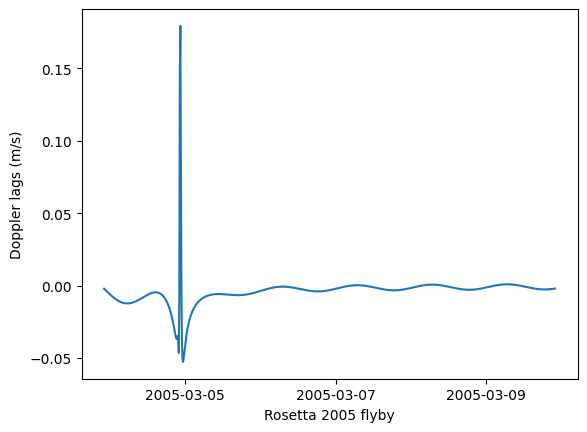

In [14]:
import matplotlib.pyplot as plt
from astropy import visualization
with visualization.time_support():
    plt.xlabel('Rosetta 2005 flyby')
    plt.ylabel('Range rate residuals (m/s)')
    plt.plot(flyby_epochs, fitter.result.residual)

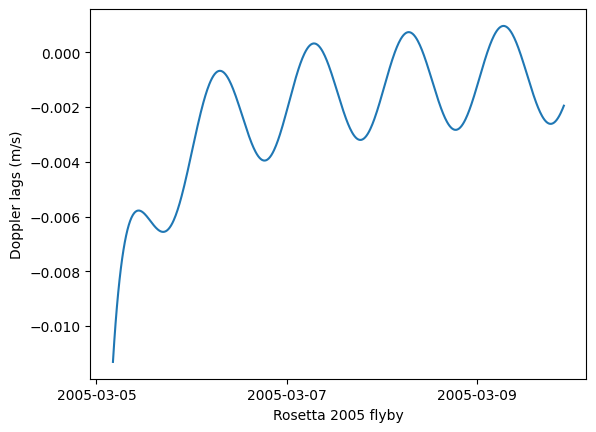

In [15]:
with visualization.time_support():
    plt.xlabel('Rosetta 2005 flyby')
    plt.ylabel('Range rate residuals (m/s)')
    plt.plot(flyby_epochs[180:], fitter.result.residual[180:])